In [1]:
from IPython import display

#What is the problem you are trying to solve with this application?


Our project is an exploration of two different levels of parallelism for enhancing the simulated annealing method of finding the optimal path in a Traveling Salesman Problem (TSP).  

The objective of the Traveling Salesman Problem is to find the shortest path in a complete undirected weighted graph that visits every node exactly once.  The weights of the edges between the nodes of the graph represent the distances between them, which can vary.  The nodes can be visited in any order, and the path ends at the starting node.  

This problem is NP-hard, which in practical terms means that the only guaranteed way to find the true optimum is to consider every possible path.  The number of truly unique possible paths within a network of N cities is equal to (N-1)!, which for even a very small network of cities is very large, making an exhaustive search computationally expensive.  Various optimization methods can be used to find a path that is close to the optimum distance while only considering a small subset of all the possible paths.  


#Describe your data in detail: where did it come from, how did you acquire it, what does it mean, etc.


We tested our application on a graph of cities taken from the Library of Traveling Salesman Problems, which is available on the Heidelberg University's Interdisciplinary Center for Scientific Computing website: 


http://www.iwr.uni-heidelberg.de/groups/comopt/software/TSPLIB95/XML-TSPLIB/instances/


The graphs on this website are downloadable in xml format, and contain the distances between each pair of cities.  We parsed these into numpy arrays that could easily be used in our program.  

#Describe your program design and why you chose the features you did.


####Simulated Annealing
One such optimization method for finding the shortest path in the Traveling Salesman Problem is simulated annealing, a serial Markov Chain Monte Carlo method that we used as a baseline for performance.  

Simulated Annealing (SA) works as follows: First, an initial path through the graph is randomly selected and the distance of this path is calculated. This starting set is then "perturbed" by randomly switching the order of two or more of the cities in the path, and the distance of this new path is calculated. The next iteration of the algorithm will either use the new path or the path from the previous iteration; this is determined probabilistically based on the difference in "energy" (in this case, the difference between the distances of the two paths, denoted ∆E) and the "temperature" (T) of that given point in the algorithm. The temperature parameter changes throughout the algorithm, adjusting the probability of accepting the next path. This probability of accepting a new path is given by the equation P(X = j) = exp(−∆E/T).  

If the temperature is high, the algorithm is more likely to accept a new path even though it returned a longer distance. Varying the temperature throughout the iterations of the algorithm allows it to consider paths that do not look promising at ﬁrst glance, but may, with slight modiﬁcation, yield better paths than those that were previously being considered. However, as the temperature decreases, longer paths become less likely to be accepted and the algorithm should be able to refine its search in a promising direction. An intuitive way to conceptualize temperature in the simulation is to think of a low temperature as representing a conservative approach and a high temperature as representing a more daring approach.  The temperature of the algorithm cools as it coalesces on a local minimum, and is periodically raised again to attempt to push the algorithm out of the local minimum to ideally find a lower local minimum.  

The main advantage of the Simulated Annealing algorithm is that it can search a very large discrete sample space without considering the entire, extremely large set of possibilities.  In addition, it does so in a strategic way by iterating upon promising tracks, but without constraining itself to one small subset of the sample space.  In this way, it avoids becoming trapped in local minima of the sample space.  Of course, because it does not consider every path, it is not guaranteed to return the true optimum.


####Parallel Tempering
Parallel Tempering is a related optimization method in which multiple processes simultaneously consider stochastic permutations of a starting path.  Each of these processes behaves analogously to simulated annealing: a path is perturbed, the new distance is calculated, and the next iteration continues with either the new path or the previous path with a probability that is given by the equation P(X = j) = exp(−∆E/T).  Rather than varying the temperature within each process as in simulated annealing, however, the temperature varies among the processes, and each process maintains a constant temperature throughout the simulation.  The processes communicate at a defined interval and swap the path that they are considering with a probability that is related to the difference in distance of the current path that each is considering.  In this way, the algorithm benefits from parallelism by using "hot" threads to be more daring in their exploration of the search space, while the "cold" ones refine the results that they receive from the hot threads with a more conservative exploration.  

We implemented simulated annealing as a baseline, and then developed two implementations of parallel tempering.  The first is a "serial parallel tempering" (SPT), in which at each step, the algorithm iterates over each process in a for-loop.  The second is "parallel parallel tempering" (PPT), which uses the Python multiprocessing module to truly run each process in parallel.  

The goal was to demonstrate that parallelism could be used to improve the path search to find an optimum with fewer total computations, and then use multiprocessing to also reduce total execution time.  

#How do you use your application (mouse and keyboard functions, input/output, etc)?


Our application is a set of python executables that call annealing and tempering functions, that can be run on the command line.  

#What is the performance of your code? What speedup and efficiency did you achieve? What optimizations did you implement to achieve this speedup?


##1) Parameter selection

###For the purposes of picking a number of processes to test parameter selection with, we calculated the run time for 10,000 iteration runs of parallel parallel tempering using a range of number of processes: 


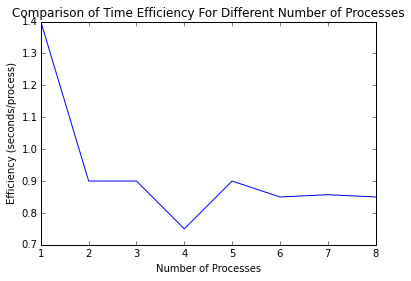

In [39]:
display.Image('Efficiency.png')

# 4 processes was the most time efficient parallel implementation, so we did our performance tests with 4 processes. 

###Next, we optimized the parameters for parallel tempering.  

There were three parameters to optimize, and there are an infinite number of combinations of these that can be used, so we did a simple gradient descent to pick these.  With some more time to dial in the best parameters, we would have done a more exhaustive search, but we deemed this exploration to be representative of the process, which could easily be extended.  As it was, the set of best parameters that we identified using this method produced quite good results, and the focus of the project was to examine parallelism, not to find the optimal parameters for the implementations.  

To search the parameters, we did some quick 'back of the envelope' calculations:

We chose to do 30 runs per parameter combination to find an average performance for each combination.  

30 runs of 10,000 iterations per combination at 3 seconds each results in 1.5 minutes per combination tested.  We wished to use no more than a half hour of run time for the parameter search, so this gave us 20 parameter combinations to check.  With three parameters to optimize (ratio between temperature of each process, number of city swaps per change, and number of iterations between swap considerations), we decided that we could test 6 values for each parameter.  

The first parameter we tested was the ratio of the temperature of the processes.  Based on a suggestion from the literature (Earl and Deem, 2005), we used a constant ratio between the processes.  We tested a range of ratios between 1 (all threads have temperature=1), sqrt(2), sqrt(3), sqrt(4), sqrt(5), and sqrt(6). 

The results follow:

####Best ratio to use is the square root of 5.0
####Time: 599.1 seconds to compute

Next, using the best temperature ratio value of sqrt(5.0), we tested a range of number of swaps per consideration.  This ranged from 1 to 6.  

####Best number of swaps to use is 1
####Time: 649.7 seconds to compute

Next, using the best temperature ratio and the best number of swaps (1), we tested a range of swap interval values.  We tested values of 10, 20, 40, 80, 160, and 320.  

####Best swapping interval is 320
####Time: 437.9 seconds to compute

Because this interval was the greatest value that we considered, we ran one more test, extending the range of values that we tested to 80, 160, 320, 480, and 640.  

####Best swapping interval is 480
####Time: 340.9 seconds to compute

We used these parameters (temperature ratio = sqrt(5.0), number of swaps = 1, swapping interval = 480) for the performance tests.  

To make the parallel tempering implementations comparable to simulated annealing, we used analogous parameters for this method.  The starting temperature was the highest temperature of the parallel tempering processes, the temperature cooled at a rate equal to the ratio of the temperature of the parallel tempering cools, and reheating occurred when the temperature reached the lowest temperature of the parallel tempering processes.  Number of swaps was the same, and the reannealing interval was set to the same swapping interval that was used in parallel tempering.  

##2a) Performance: Accuracy vs. Number of Iterations

We ran each of the three algorithms (PPT, SPT, and SA) for 1,000,000 iterations to compare their performance.  We did this for 25 runs of each algorithm, using the same sets of starting paths for each method.  For the case of SA (which only uses a single path at any given moment), we used the first starting path of the 4 starting paths that were used for parallel tempering.  Then we took an average of the current best value found at each time step for the 25 runs.  The average accuracy of each algorithm with respect to iteration count is presented below.  We zoom into the first 50,000 iterations of each algorithm because the parallel tempering algorithms converge to the optimum so quickly that their paths are difficult to see on a plot of the full runs.  

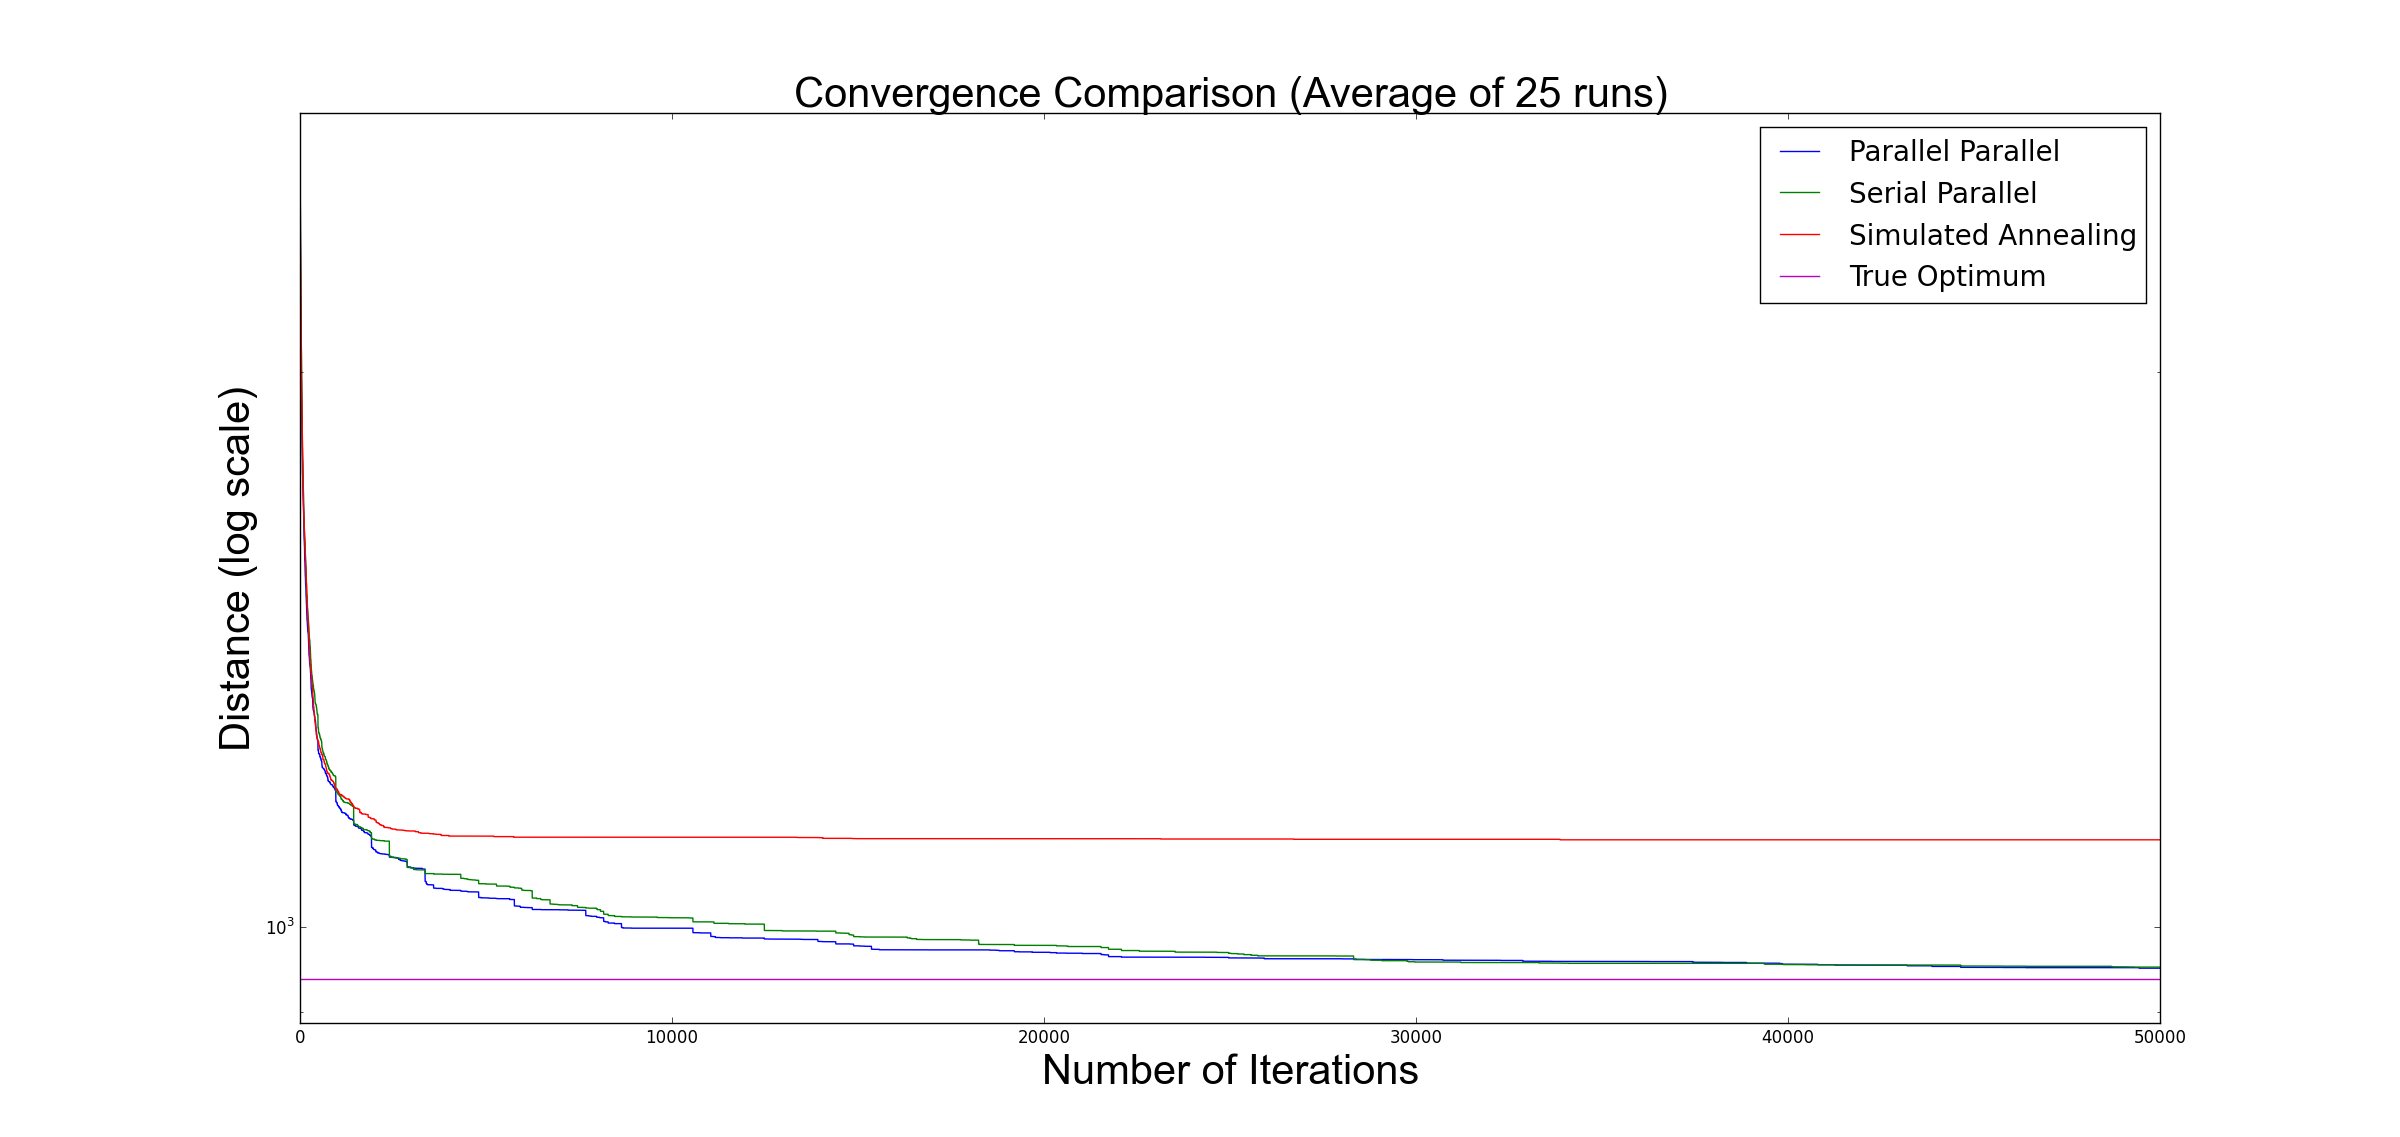

In [2]:
display.Image('AccuracyVsIterations.png')

As expected, the two implementations of parallel tempering had nearly identical results.  Because their parameters were identical and their underlying mechanism is the same, they should behave identically.  Simulated Annealing showed a much slower approach towards the optimum, and based on the flat shape of its average best path found over iterations, it appears that SA frequently gets caught in local minima.  It stands to reason that this would happen less frequently for both PT algorithms because they always have one process running at a high temperature, continuously making daring explorations.   

##2b) Performance: Accuracy vs. Total Compute

Of course, the above comparison is not a very fair comparison between PT and SA of the convergence to the optimum because the PT algorithms consider four paths at each iteration.  Not only have they explored a much larger section of the solution space, but if we were to try to extend our observations to make predictions about the behavior of these algorithms for problems with higher computational overhead (as opposed to distance calculation, which is very fast), the accuracy vs. iteration count comparison would greatly misrepresent the difference in performance between the algorithms.  

We can make a more fair comparison between SA and PT by plotting their performance against the total number of distance calculations that have been made.  The results appear below.  

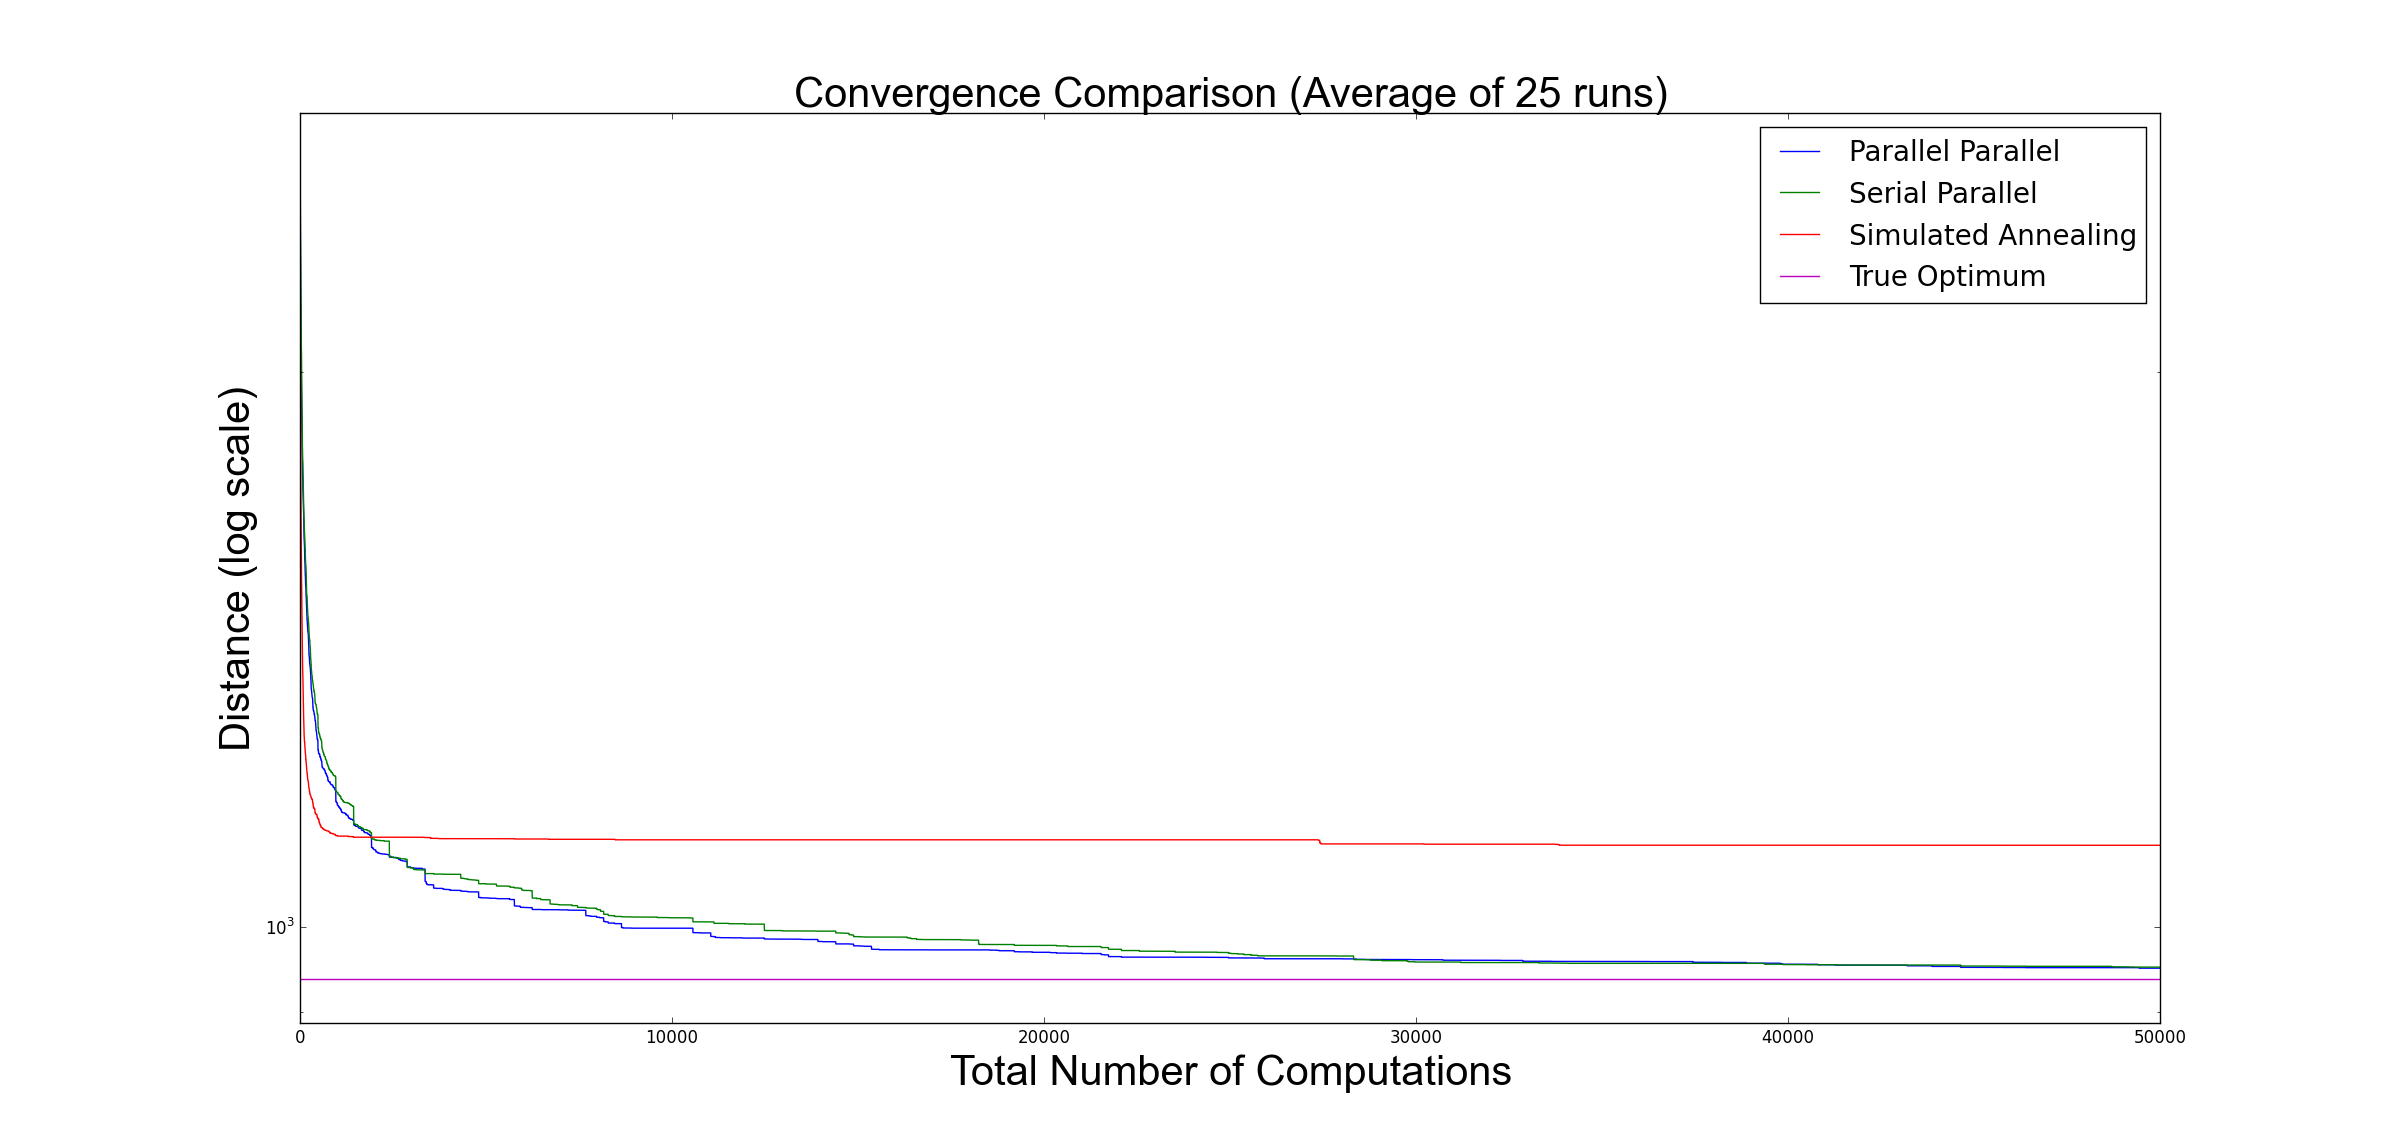

In [4]:
display.Image('AccuracyVsComputation.png')

In this comparison, SA converges towards the optimum more quickly in the first few hundred iterations, but the benefit of multiple processes becomes apparent by about the 2000th computation, when parallel tempering continues to converge toward the optimum by better avoiding local minima and continuously improving.  

In [ ]:
##2c) Performance: Accuracy vs. Time

Obviously, we are probably not primarily concerned with the total number of computations that can be performed, but rather are more interested in whether a more accurate result is returned with respect to actual run time.  To observe this behavior, we performed the same test, but recorded the elapsed time at each computation.  

In [ ]:
2d) Overall Speedup

In [7]:
import time

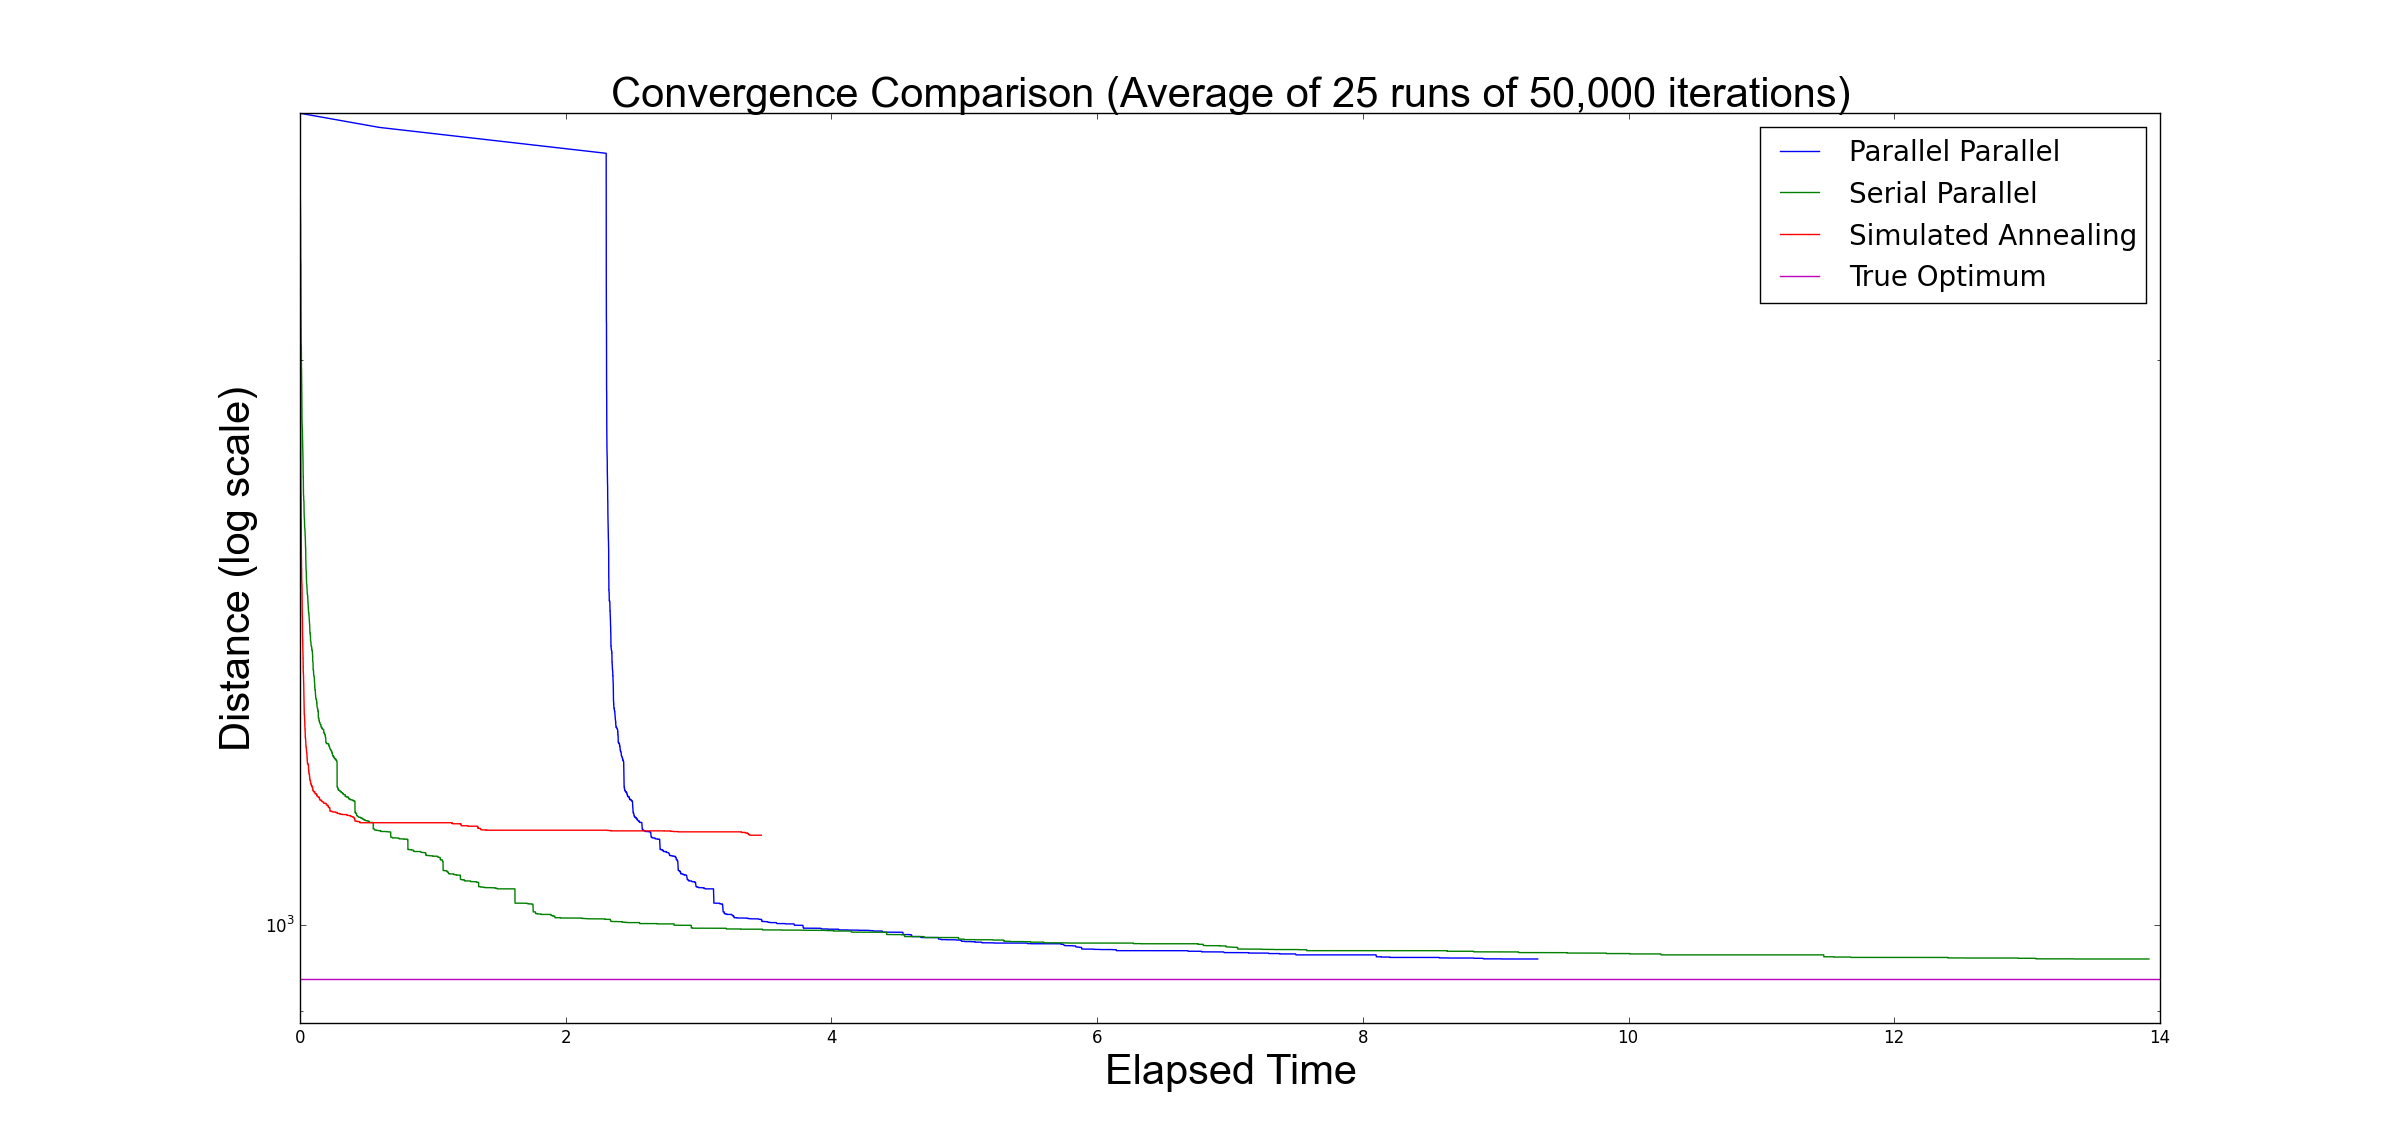

In [15]:
display.Image('AccuracyVsTime_50kIter.png')

In [19]:
np.int(1.5)

1

In [ ]:
2e) Run-time versus swapping interval

#What interesting insights did you gain from this project?


#What extensions and improvements can you suggest?


#What did you most enjoy about working on this project? What was the most challenging aspect? What was the most frustrating? What would you do differently next time?

## References

David J. Earl, David J. and Deem, Michael W. 2005.  "Parallel tempering: Theory, applications, and new perspectives" http://www.math.pitt.edu/~cbsg/Materials/Earl_ParallelTempering.pdf

In [1]:
# Import packages
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
import pandas as pd

# Import files
from annealing_helper_functions import distance, changepath, simulated_annealing, serial_parallel_tempering
from parallelism import parallel_parallel_tempering
from timer import Timer
from xml_parse import parse_xml_graph

# Parse graph
graph = parse_xml_graph('fri26.xml')
#Square matrix
assert graph.shape[0] == graph.shape[1]
size = graph.shape[0]

# Hardcoded best path to validate distance calculations, zero-indexed
bestpath = np.asarray([x-1 for x in [1, 25, 24, 23, 26, 22, 21, 17, 18, 20, 19, 16, 11, 12, 13, 15, 14, 10, 9, 8, 7, 5, 6, 4, 3, 2]])
print "Best path: " + str(bestpath)
print "Best path length: " + str(distance(graph, bestpath)) + "\n"

Best path: [ 0 24 23 22 25 21 20 16 17 19 18 15 10 11 12 14 13  9  8  7  6  4  5  3  2
  1]
Best path length: 937.0



In [2]:
# A random initial path, used as a starting point for the different optimizations to compare
initial_path = np.random.permutation(size)
print "Initial path: " + str(initial_path)
print "Initial path length: " + str(distance(graph, initial_path)) + "\n"

Initial path: [22  8 17 10  5 20  7  1  0  3 19 25 24  9 16 13 11 23 14 21  4 12 18  2 15
  6]
Initial path length: 2975.0



### I create a list of a million possible paths to get an idea about the distribution of all possible paths.

In [3]:
li = []
for i in range(1000000): li.append(distance(graph,np.random.permutation(size)))

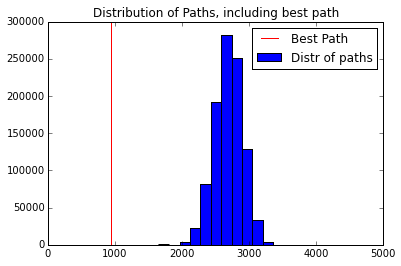

In [20]:
plt.hist(li, bins=12, label="Distr of paths")
plt.axvline(distance(graph,bestpath), color = 'r', label = "Best Path")
plt.xlim([0,5000])
plt.legend(loc='best')
plt.title('Distribution of Paths, including best path');

### In this sample of 1 million paths, the average path length was 2693 and the minimum path length was 1725, so the chances of randomly finding a path as short as the true minimum (937) are quite low.  When you think about it this way, it's kind of amazing that you can get within a couple hundred of the true minimum pretty easily by considering far less than 1% of all possible paths.  

In [33]:
pd.Series(li).describe()

count    1000000.000000
mean        2693.156735
std          208.645040
min         1725.000000
25%         2554.000000
50%         2699.000000
75%         2839.000000
max         3538.000000
dtype: float64

### Example of Simulated Annealing:

In [15]:
iterr = 10000
initial_temp = 5
cool = 0.8
nbefore = 10
nswaps = 3
reheat = 0.2

In [16]:
%%time
# 10000 iteration runs of simulated annealing take about 1.2 seconds on my computer
solution, history= simulated_annealing(graph, distance, 
                                    initial_path, initial_temp, nbefore,
                                    iterr, changepath, nswaps, reheat, cool)
print "Iterations: {:.2E}".format(iterr)
print "Calculated path: " + str(solution)
print "Calculated path length: " + str(distance(graph, solution))

Iterations: 1.00E+04
Calculated path: [ 7  8  6  5  3  1  4  2  9 13 14  0 24 23 22 25 21 20 16 12 11 10 15 19 17
 18]
Calculated path length: 1160.0
Wall time: 1.45 s


### Here is an example what the history of the energies and temperatures look like:

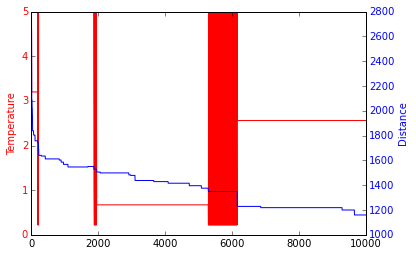

In [17]:
fig, ax1 = plt.subplots()

ax1.plot(range(iterr + 1), [row[2] for row in history], 'r')
ax1.set_ylabel('Temperature', color='r')
for t1 in ax1.get_yticklabels():
    t1.set_color('r')
ax2 = ax1.twinx()
ax2.plot(range(iterr + 1), [row[0] for row in history], 'b-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Distance', color='b')
for t2 in ax2.get_yticklabels():
    t2.set_color('b')



### You can get a really good idea of how each parameter changes the behavior by examining the graph.  Ideally, the Distance will bounce around in the beginning, settle down at a low level, bounce around again once it heats back up, and then settle down again, ideally at a lower level than last time.  

Iterations: 1.00E+04
Calculated path: [15  9 13 14 12 11 20 25 17 16  8  4  5  3 10 21 22 23 24  0  1  2  6  7 19
 18]
Calculated path length: 1264.0


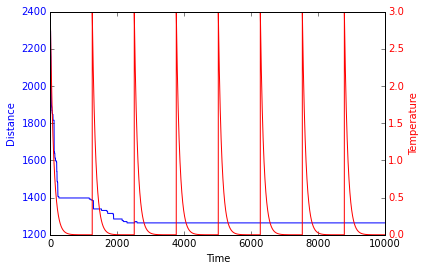

In [87]:
iterr = 10000
initial_temp = 3
cool = 0.99
nbefore = 100
nswaps = 1
reheat = 0.00001

# 10000 iteration runs of simulated annealing take about 1.2 seconds on my computer
solution, history, history_temp = simulated_annealing(graph, distance, 
                                    initial_path, initial_temp, nbefore,
                                    iterr, changepath, nswaps, reheat, cool)
print "Iterations: {:.2E}".format(iterr)
print "Calculated path: " + str(solution)
print "Calculated path length: " + str(distance(graph, solution))

fig, ax1 = plt.subplots()

ax1.plot(range(iterr + 1), history, 'b-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax2 = ax1.twinx()
ax2.plot(range(iterr + 1), history_temp, 'r')
ax2.set_ylabel('Temperature', color='r')
for t2 in ax2.get_yticklabels():
    t2.set_color('r')

Iterations: 1.00E+04
Calculated path: [15  9 13 14  2  8  7  6  4  5  3  1  0 24 23 22 25 21 20 11 12 10 16 17 19
 18]
Calculated path length: 1039.0


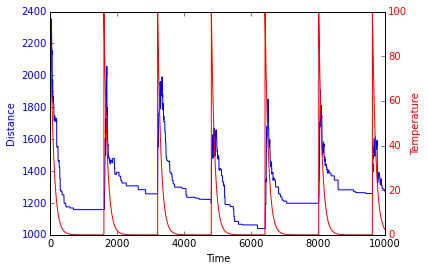

In [88]:
iterr = 10000
initial_temp = 100
cool = 0.99
nbefore = 100
nswaps = 1
reheat = 0.00001

# 10000 iteration runs of simulated annealing take about 1.2 seconds on my computer
solution, history, history_temp = simulated_annealing(graph, distance, 
                                    initial_path, initial_temp, nbefore,
                                    iterr, changepath, nswaps, reheat, cool)
print "Iterations: {:.2E}".format(iterr)
print "Calculated path: " + str(solution)
print "Calculated path length: " + str(distance(graph, solution))

fig, ax1 = plt.subplots()

ax1.plot(range(iterr + 1), history, 'b-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax2 = ax1.twinx()
ax2.plot(range(iterr + 1), history_temp, 'r')
ax2.set_ylabel('Temperature', color='r')
for t2 in ax2.get_yticklabels():
    t2.set_color('r')

Iterations: 1.00E+04
Calculated path: [13 15 18 19 17 22 23 24 21 25 20 16 11 12 10  9  8  7  6  4  5  3  2  1  0
 14]
Calculated path length: 1046.0


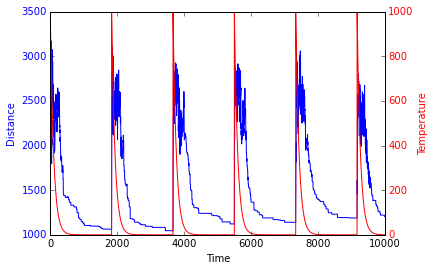

In [95]:
iterr = 10000
initial_temp = 1000
cool = 0.99
nbefore = 1
nswaps = 1
reheat = 0.00001

# 10000 iteration runs of simulated annealing take about 1.2 seconds on my computer
solution, history, history_temp = simulated_annealing(graph, distance, 
                                    initial_path, initial_temp, nbefore,
                                    iterr, changepath, nswaps, reheat, cool)
print "Iterations: {:.2E}".format(iterr)
print "Calculated path: " + str(solution)
print "Calculated path length: " + str(distance(graph, solution))

fig, ax1 = plt.subplots()

ax1.plot(range(iterr + 1), history, 'b-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax2 = ax1.twinx()
ax2.plot(range(iterr + 1), history_temp, 'r')
ax2.set_ylabel('Temperature', color='r')
for t2 in ax2.get_yticklabels():
    t2.set_color('r')

### We need to optimize the parameters to be able to make a comparison between simulated annealing and parallel tempering.  There are five parameters that can be tuned, and the range of values for these is infinite.  This means that there are also infinite possibilities for the combinations of parameters.  Beyond this, we want to know how well each parameter combination performs on average, so we would want to run each parameter combination many times to examine its behavior.  
###This makes a rigorous exploration of the parameters very time-comsuming, so we do a very limited exploration of the parameters as a simplified example of how the parameters can first be optimized for each implementation to compare performance between simulated annealing and parallel tempering for parameters that have been optimized for both.  We perform a simple gradient descent of the parameter combinations by exploring a range of values for the first parameter while holding the other four constant, then use the best value from this comparision to explore a range of values for the second, and so on.  

### First I do a bit of a 'back of the envelope' calculation to do the parameter exploration in a limited amount of time.  A single 10,000 iteration run of simulated annealing takes about 1.2 seconds, so exploring a single parameter combination for 20 times to get an average should take less than 30 seconds.  Therefore, if I hold four of the parameters constant and explore a range of 10 values for the fifth parameter, each parameter exploration should take about five minutes.  Then, exploring all five should have a run time of roughly 25 minutes.  

### To isolate the variance that would be introduced by the variety of starting paths, we will use a single random starting paths for all 20 runs of each parameter combination.  

In [58]:
%%time
iterr = 10000

# These values are our starting points, and represent the initial value that will be considered while the earlier 
#    parameters are explored, and will then be updated after its best value is found.  At the end I will return the 
#   updated values of all five parameters, representing the best value for each that was found in its exploration.  
# These were selected based on a cursory, unscientific tinkering of parameter values.  
temp = 5
cool = 0.9
nbefore = 500
nswaps = 5
reheat = 0.0125

# These are the ranges of values to explore for each parameter.  
initial_temps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
initial_cools = [0.7, 0.8, 0.85, 0.9, 0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999]
initial_nbefores = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
initial_nswaps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
initial_reheat = [0.4, 0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625, 0.00078125]

# List of means for each temperature
mean_dists = []

# Run 20 simulations of each potential initial temperature
for initial_temp in initial_temps:
    # List of distances for each run of this temperature
    distances = []
    for i in range(20):
        solution, history, history_temp = simulated_annealing(graph, distance, 
                                    initial_path, initial_temp, nbefore,
                                    iterr, changepath, nswaps, reheat, cool)
        distances.append(distance(graph,solution))
    mean_dists.append(np.mean(distances))

# Create a dictionary of the mean
temp_dist_dict = dict(zip(mean_dists,initial_temps))

# Find the minimum average distance that was found:
min_dist = np.min(temp_dist_dict.keys())

# Find the temperature corresponding to that distance
best_temp = temp_dist_dict[min_dist]

# The rest are repetitions of the above for each parameter:
mean_dists = []
for cool in initial_cools:
    distances = []
    for i in range(20):
        solution, history, history_temp = simulated_annealing(graph, distance, 
                                    initial_path, initial_temp, nbefore,
                                    iterr, changepath, nswaps, reheat, cool)
        distances.append(distance(graph,solution))
    mean_dists.append(np.mean(distances))

cool_dist_dict = dict(zip(mean_dists,initial_cools))
min_dist = np.min(cool_dist_dict.keys())
cool = cool_dist_dict[min_dist]


mean_dists = []
for nbefore in initial_nbefores:
    distances = []
    for i in range(20):
        solution, history, history_temp = simulated_annealing(graph, distance, 
                                    initial_path, initial_temp, nbefore,
                                    iterr, changepath, nswaps, reheat, cool)
        distances.append(distance(graph,solution))
    mean_dists.append(np.mean(distances))
nbefore_dist_dict = dict(zip(mean_dists,initial_nbefores))
min_dist = np.min(nbefore_dist_dict.keys())
nbefore = nbefore_dist_dict[min_dist]

mean_dists = []
for nswaps in initial_nswaps:
    distances = []
    for i in range(20):
        solution, history, history_temp = simulated_annealing(graph, distance, 
                                    initial_path, initial_temp, nbefore,
                                    iterr, changepath, nswaps, reheat, cool)
        distances.append(distance(graph,solution))
    mean_dists.append(np.mean(distances))
nswaps_dist_dict = dict(zip(mean_dists,initial_nswaps))
min_dist = np.min(nswaps_dist_dict.keys())
nswaps = nswaps_dist_dict[min_dist]

mean_dists = []
for reheat in initial_reheat:
    distances = []
    for i in range(20):
        solution, history, history_temp = simulated_annealing(graph, distance, 
                                    initial_path, initial_temp, nbefore,
                                    iterr, changepath, nswaps, reheat, cool)
        distances.append(distance(graph,solution))
    mean_dists.append(np.mean(distances))
reheat_dist_dict = dict(zip(mean_dists,initial_reheat))
min_dist = np.min(reheat_dist_dict.keys())
reheat = reheat_dist_dict[min_dist]

print "Best temperature found: ", temp
print "Best cool found: ", cool
print "Best nbefore found: ", nbefore
print "Best nswaps found:", nswaps
print "Best reheat: ", reheat

Best temperature found:  5
Best cool found:  0.9
Best nbefore found:  1000
Best nswaps found: 1
Best reheat:  0.4
Wall time: 24min 55s


In [90]:
solution, history, history_temp = simulated_annealing(graph, distance, 
                                    initial_path, initial_temp, nbefore,
                                    iterr, changepath, nswaps, reheat, cool)

In [93]:
%%time
iterr = 4000000
solution, history, history_temp = simulated_annealing(graph, distance, 
                                    initial_path, initial_temp, nbefore,
                                    iterr, changepath, nswaps, reheat, cool)
print distance(graph,solution)

937.0
Wall time: 4min 17s


In [98]:
initial_temps = [1, np.sqrt(5), np.sqrt(5**2), np.sqrt(5**3)]
initial_path = [initial_path, initial_path, initial_path, initial_path]

nbefore = 100
nswaps = 3


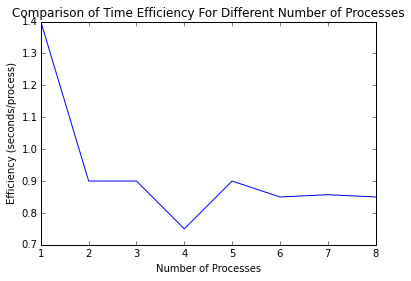

In [33]:
ba = '####1 processes: 1.4 sec####2 processes: 1.8 sec####3 processes: 2.7 sec####4 processes: 3.0 sec####5 processes: 4.5 sec####6 processes: 5.1 sec####7 processes: 6.0 sec####8 processes: 6.8 sec'
bu = [ba[(24*i+17):(24*i+20)] for i in range(8)]
num_processors = np.array(range(8))+np.array([1]*8)
plt.xlabel('Number of Processes')
plt.ylabel('Efficiency (seconds/process)')
plt.title('Comparison of Time Efficiency For Different Number of Processes')
plt.plot(num_processors, [np.float(bu[i])/num_processors[i] for i in range(8)])
